In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import csv
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Data

In [4]:

ds_path = '/kaggle/input/kinetics400-frames/dataset'
img_height,img_width=224,224
batch_size=32

In [5]:
import cv2
res = cv2.imread('/kaggle/input/kinetics400-frames/dataset/abseiling/video_0_frame_0001.jpg')
res.shape

(1080, 1920, 3)

In [6]:
num_class = len([d for d in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, d))])
print(f"Number of classes: {num_class}")

Number of classes: 398


In [7]:

# 80%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ds_path,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 103238 files belonging to 398 classes.
Using 77429 files for training.


In [8]:

# 20%
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ds_path,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 103238 files belonging to 398 classes.
Using 25809 files for validation.


In [9]:

class_names = train_ds.class_names
print(len(class_names))

398


In [10]:
print(type(class_names))

<class 'list'>


In [11]:

field = ['name']
with open('/kaggle/working/kinetics_labels.csv', 'w', newline='') as f:
     
    # using csv.writer method from CSV package
    writer = csv.writer(f)
    writer.writerow(field)
    for label in class_names:
        writer.writerow([label])

In [12]:

augmentation_layers = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(factor=0.1),  
    keras.layers.GaussianNoise(0.1),  
])


def data_augmentation(x):
    return augmentation_layers(x)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
 

In [13]:

pretrained_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,           
    input_shape=(224, 224, 3),   
    weights='imagenet'           
)

# pretrained_model.trainable = False
pretrained_model.trainable = True 
for layer in pretrained_model.layers[:-5]:
    layer.trainable = False

inputs = keras.Input(shape=(224,224,3))

x = pretrained_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_class, activation='softmax')(x)

efficientnetv2s = keras.Model(inputs, outputs)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
efficientnetv2s.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       204,174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,191,406 (80.84 MB)

 Trainable params: 1,190,286 (4.54 MB)

 Non-trainable params: 20,001,120 (76.30 MB)

In [15]:

efficientnetv2s.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/best_model.keras',  # Đường dẫn lưu mô hình
    monitor='val_accuracy',    # Giám sát validation accuracy
    save_best_only=True,       # Chỉ lưu khi mô hình tốt hơn
    mode='max',                # Lưu khi val_accuracy đạt max
    verbose=1
)

epochs=15
history = efficientnetv2s.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]
)
 

Epoch 1/15
   2/2420 ━━━━━━━━━━━━━━━━━━━━ 3:02 76ms/step - accuracy: 0.0000e+00 - loss: 6.0297    

I0000 00:00:1723621443.494432     199 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.1997 - loss: 4.1017
Epoch 1: val_accuracy improved from -inf to 0.48460, saving model to /kaggle/working/best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1392s 532ms/step - accuracy: 0.1997 - loss: 4.1015 - val_accuracy: 0.4846 - val_loss: 2.2093
Epoch 2/15
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4061 - loss: 2.6099
Epoch 2: val_accuracy improved from 0.48460 to 0.57236, saving model to /kaggle/working/best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1123s 464ms/step - accuracy: 0.4061 - loss: 2.6099 - val_accuracy: 0.5724 - val_loss: 1.8092
Epoch 3/15
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4876 - loss: 2.1759
Epoch 3: val_accuracy improved from 0.57236 to 0.62033, saving model to /kaggle/working/best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1129s 466ms/step - accuracy: 0.4876 - loss: 2.1759 - val_accuracy: 0.6203 - val_loss: 1.5762
Epoch 4/15
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7110 - loss: 1.1294
Epoch 11: val_accuracy improved from 0.76179 to 0.77310, saving model to /kaggle/working/best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1084s 448ms/step - accuracy: 0.7110 - loss: 1.1294 - val_accuracy: 0.7731 - val_loss: 0.9993
Epoch 12/15
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7207 - loss: 1.0904
Epoch 12: val_accuracy improved from 0.77310 to 0.77663, saving model to /kaggle/working/best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1086s 449ms/step - accuracy: 0.7207 - loss: 1.0904 - val_accuracy: 0.7766 - val_loss: 1.0038
Epoch 13/15
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7313 - loss: 1.0412
Epoch 13: val_accuracy improved from 0.77663 to 0.78511, saving model to /kaggle/working/best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1124s 464ms/step - accuracy: 0.7313 - loss: 1.0412 - val_accuracy: 0.7851 - val_loss: 0.9740
Epoch 14/15
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 435

In [17]:
import pickle
Pkl_Filename = "/kaggle/working/Pickle_RL_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(resnet_model, file)
    
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

<Functional name=functional_1, built=True>

In [18]:
# Save the model
efficientnetv2s.save('/kaggle/working/actionRecognition.h5')

# Load the model
reconstructed_model = tf.keras.models.load_model('/kaggle/working/actionRecognition.h5')

In [19]:
json_string = efficientnetv2s.to_json()
from keras.models import model_from_json

model_architecture = model_from_json(json_string)
model_architecture.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       204,174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,381,694 (85.38 MB)

 Trainable params: 1,190,286 (4.54 MB)

 Non-trainable params: 20,001,120 (76.30 MB)

 Optimizer params: 1,190,288 (4.54 MB)

In [20]:
with open('/kaggle/working/model_architecture.json', 'w') as json_file:
    json_file.write(json_string)

In [21]:
from IPython.display import FileLink

# Tạo liên kết tải xuống cho mô hình
FileLink('/kaggle/working/model_architecture.json')


/kaggle/working/model_architecture.json

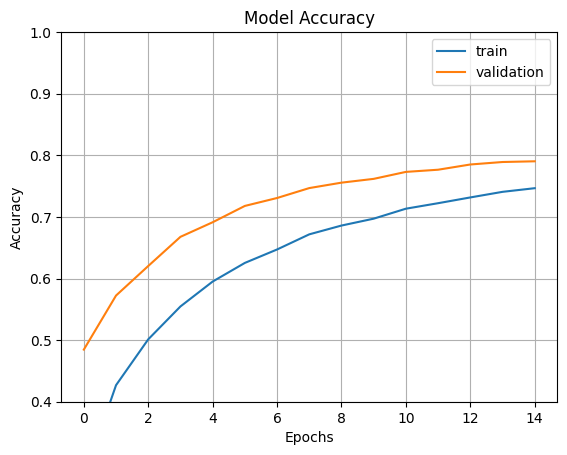

In [23]:

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

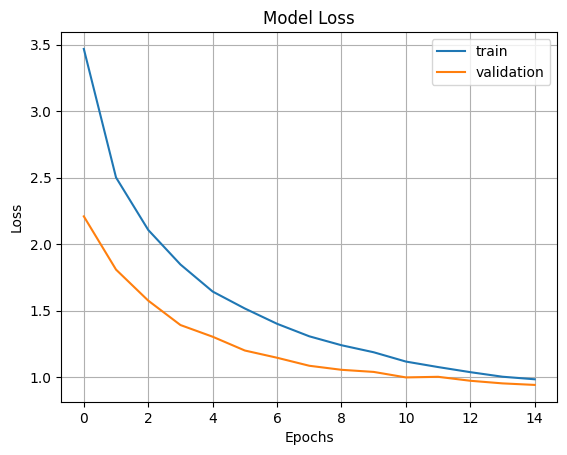

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Continue training for 10 epochs

In [35]:
old_model = tf.keras.models.load_model('/kaggle/working/20_20.h5')


old_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/new_best_model.keras',  # Đường dẫn lưu mô hình
    monitor='val_accuracy',    # Giám sát validation accuracy
    save_best_only=True,       # Chỉ lưu khi mô hình tốt hơn
    mode='max',                # Lưu khi val_accuracy đạt max
    verbose=1
)

epochs=10
new_history = old_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]
)
 

Epoch 1/10
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7478 - loss: 0.9832
Epoch 1: val_accuracy improved from -inf to 0.79763, saving model to /kaggle/working/new_best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1266s 488ms/step - accuracy: 0.7478 - loss: 0.9832 - val_accuracy: 0.7976 - val_loss: 0.9317
Epoch 2/10
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7612 - loss: 0.9337
Epoch 2: val_accuracy improved from 0.79763 to 0.80239, saving model to /kaggle/working/new_best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1110s 458ms/step - accuracy: 0.7612 - loss: 0.9337 - val_accuracy: 0.8024 - val_loss: 0.9232
Epoch 3/10
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7626 - loss: 0.9217
Epoch 3: val_accuracy improved from 0.80239 to 0.80809, saving model to /kaggle/working/new_best_model.keras
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1110s 458ms/step - accuracy: 0.7626 - loss: 0.9217 - val_accuracy: 0.8081 - val_loss: 0.9162
Epoch 4/10
2420/2420 ━━━━━━━━━━━━━

In [44]:
old_model.save('./kaggle/working/actionRecognition.keras')

In [39]:
import pickle
Pkl_Filename = "/kaggle/working/actionRecognition.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(old_model, file)
    
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

<Functional name=functional_1, built=True>

In [40]:
json_string = old_model.to_json()
with open('/kaggle/working/model_architecture.json', 'w') as json_file:
    json_file.write(json_string)

from keras.models import model_from_json

model_architecture = model_from_json(json_string)
model_architecture.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       204,174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,571,980 (89.92 MB)

 Trainable params: 1,190,286 (4.54 MB)

 Non-trainable params: 20,001,120 (76.30 MB)

 Optimizer params: 2,380,574 (9.08 MB)

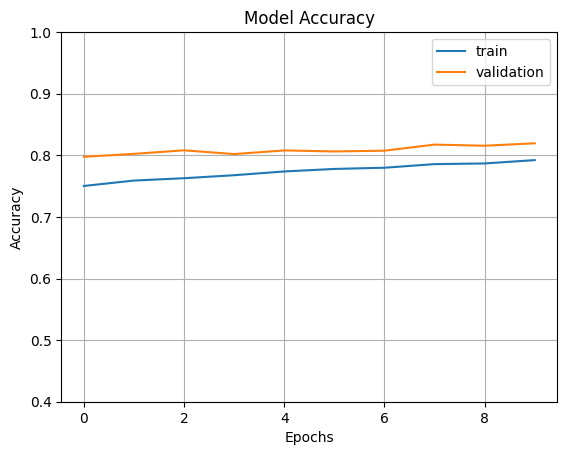

In [41]:

fig1 = plt.gcf()
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

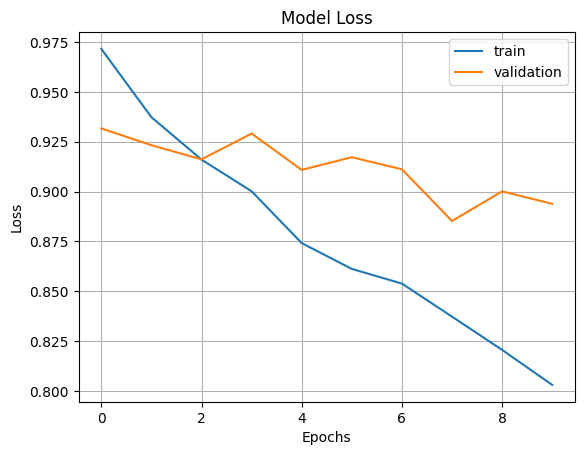

In [42]:
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()